# Project 5: Integrated Project #1
*Identify Patterns That Drive the Success of Video Games*

### Prepare the Data

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

In [2]:
# load the dataset from the csv file into a dataframe
df = pd.read_csv('games.csv')

# print 5 sample rows of the dataframe
print(df.sample(5))

                             Name Platform  Year_of_Release         Genre  \
14996  Neverwinter Nights Diamond       PC           2004.0  Role-Playing   
6491               Riding Spirits      PS2           2002.0        Racing   
15507            Hellgate: London       PC           2007.0  Role-Playing   
3517                  Rock Band 3      PS3           2010.0          Misc   
11164     Dreamer Series: Teacher       DS           2009.0    Simulation   

       NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score User_Score  \
14996      0.00      0.02       0.0         0.00           NaN        8.2   
6491       0.13      0.10       0.0         0.03          59.0          9   
15507      0.00      0.02       0.0         0.00          70.0        6.3   
3517       0.43      0.08       0.0         0.05          91.0          8   
11164      0.08      0.00       0.0         0.01           NaN        tbd   

      Rating  
14996      M  
6491       E  
15507      M  
3517       T  

In [3]:
# convert the column names to lowercase
df.columns = df.columns.str.lower()

In [4]:
# get info about df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


In [5]:
# count number of missing values per column and save to a new dataframe
mis_values = df.isnull().sum().to_frame('missing_values')

# calculate the numeber of missing values out of the total number of rows per column
mis_values['%'] = round(df.isnull().sum()/len(df),3)

# sort the dataframe by the % of missing values in descending order
mis_values.sort_values(by='%', ascending=False)

,missing_values,%
critic_score,8578,0.513
rating,6766,0.405
user_score,6701,0.401
year_of_release,269,0.016
name,2,0.000
platform,0,0.000
genre,2,0.000
na_sales,0,0.000
eu_sales,0,0.000
jp_sales,0,0.000


The column `year_of_release` should be an integer for potential calculations and compatibility with common analysis libraries. There is no purpose to the decimal value for a year.

The `user_score` column should be a float column becasue it is a numeric column that contains non-zero values after the decimal point. Plus, it's ideal to have a consistent data type with the other score-related column (`critic_score`). It should also be scaled to use the same scale as the `critic_score` column so we can logically analyze them together.

Here's a summary of the columns with missing values:
- **name:** There are 2 missing values to investigate.
- **year_of_release:** There are a few hundred missing values. We can use the median year_of_release value per platform to fill missing `year_of_release` values for the given `platform` then convert the column to an integer data type.
- **genre:** There are 2 missing values to investigate. Perhaps we can infer what the `genre` is from other data in the row--to be determined.
- **critic_score:** More than half of the values are missing. This is substantial so we may need to leave these values as they are since they may represent games that were never rated by critics. We can leave these values as NaN if they aren't rated and change 'tbd' values to NaN as well. We can still calculate statistics about this score while acknowledging games that don't have user ratings.
- **user_score:** There are over 6,000 missing values--so also a substantial amount. It's possible that there are not enough publically available user reviews for lesser known games or it's hard to collect them for different sources across the internet reliably. We can leave these values as NaN if they aren't rated and change 'tbd' values to NaN as well. We can still calculate statistics about this score while acknowledging games that don't have user ratings.
- **rating:** Over 6k values are missing for the ESRB rating as well; lesser-known games may not receive these ratings or perhaps whether or not a game is rated is dependent on its platform or year of release. The answer to that will help to inform how to handle these missing values. Since this column is an object, it may be a good idea to replace missing values with a value of 'Unknown'.

In [6]:
# fill missing year_of_release values with the median year_of_release value for each platform
df['year_of_release'] = df.groupby('platform')['year_of_release'].transform(lambda x: x.fillna(x.median())).astype(int)

# convert 'tbd' values in 'user_score' to NaN
df['user_score'] = df['user_score'].replace('tbd', np.nan)

# convert 'user_score' to float and multiply by 10
df['user_score'] = df['user_score'].astype(float)*10

We multiplied the user_score column by 10 to transform it to be on the same scare as the critic_score column for ease of data interpretation and subsequent calculations.

In [ ]:
# investigate whether older year_of_release values influences missing rating values
print(f"Count of games by rating for release years before 1980:\n\n{df[df['year_of_release'] < 1980]['rating'].value_counts(dropna=False)}")

# Investigate whether certain platforms have more missing rating values
print(f"\n\nCount of games by rating, platform:\n\n{df.groupby(by='platform')['rating'].value_counts(dropna=False)}")


Count of games by rating for release years before 1980:

Series([], Name: rating, dtype: int64)


Count of games by rating, platform:

platform  rating
2600      NaN       133
3DO       NaN         3
3DS       NaN       292
          E          92
          E10+       76
                   ... 
XOne      M          70
          NaN        61
          E          45
          T          40
          E10+       31
Name: rating, Length: 106, dtype: int64


There doesn't seem to be an obvious reason why `rating` values tend to be missing. We'll replace them with a value of 'Unknown/Not Rated' and keep an eye out for any other possible explanations as we proceed with the analysis.

In [8]:
# replace missing values in 'rating' with 'Unknown/Not Rated'
df['rating'] = df['rating'].fillna('Unknown/Not Rated')

In [9]:
# check rows where name is missing
na_name = df[df['name'].isna()]
print(f"Rows with NaN name values:\n\n{na_name}")

# replace missing name values with 'Unknown'
df['name'] = df['name'].fillna('Unknown')


Rows with NaN name values:

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score             rating  
659           0.08           NaN         NaN  Unknown/Not Rated  
14244         0.00           NaN         NaN  Unknown/Not Rated  


I decided to replace the missing name values with 'Unknown' because one of the two games has a substantial amount of over $2M in total_sales.

These are also the two rows where the value for genre is missing so I'll update those NaN values with 'Unknown' as well.

In [10]:
# replace missing genre values with 'Unknown'
df['genre'] = df['genre'].fillna('Unknown')

In [11]:
# create a new column 'total_sales' that sums up the sales from all regions
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [12]:
# verify that df data types and missing values are as expected now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16715 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16715 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16715 non-null  object 
 11  total_sales      16715 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.5+ MB


In [13]:
# describe the cleaned data
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000,7590.000000,16715.000000
mean,2006.473347,0.263377,0.145060,0.077617,0.047342,68.967679,71.250461,0.533396
std,5.897579,0.813604,0.503339,0.308853,0.186731,13.938165,15.000061,1.548261
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,64.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,75.000000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,82.000000,0.470000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,97.000000,82.540000


# Analyze the Data

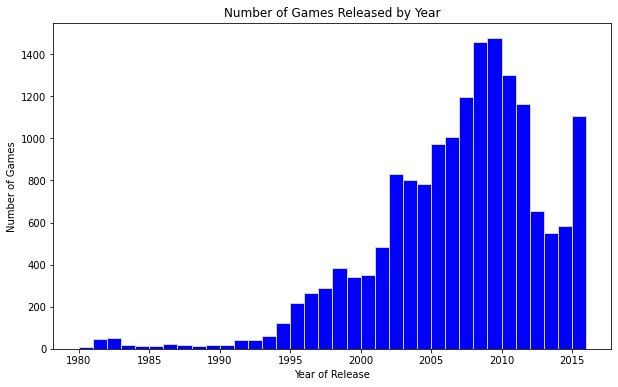

In [14]:
# set the figure size
plt.figure(figsize=(10, 6))

# plot a histogram of the number of games released by year
plt.hist(df['year_of_release'],
         bins=36,
         color='blue',
         edgecolor='lightgray'
         )

# add labels and title to the plot
plt.xlabel('Year of Release')
plt.ylabel('Number of Games')
plt.title('Number of Games Released by Year')


# display the plot
plt.show()

The number of video games per year started to ramp up in the 90's then grew sharply after 20233, peaking in 2008. The number of games per year fell drastically after 2011, but stayed above pre-2003 annual levels. The most recent year in the dataset, 2016, experienced a surge. 

Perhaps 2012-2015 just weren't big years for video game platforms, or there was an industry shift to focus on producing more complex, highly-anticipated games vs. focusing on the quantity of games released.

There was a very low volume of annual games released in the 80's and, interestingly, the highest volume occured in the early 80's (1982 and 1983). Maybe the advent of video games produced a small initial peak. Then again, perhaps some of our games with missing `release_year` data were actually released in the 80's; we can't be sure at the moment.

In [15]:
# investigate what game was released on DS in 1985 because this doesn't make sense  
incorrect_ds_game = df[(df['platform'] == 'DS') & (df['year_of_release'] == 1985)]

# correct the year of release for the game 'Strongest Tokyo University Shogi DS ' on the DS platform to 2007 (I googled the true release year)
df.loc[df['name'] == 'Strongest Tokyo University Shogi DS', 'year_of_release'] = 2007

# create a column to indicate if the game had over 0.0 in total sales for the latest year
df['has_sales_in_2016'] = (df['year_of_release'] == 2016) & (df['total_sales'] > 0.0)

# calculate the total sales for each platform, whether it had sales in 2016, and its min and max release years and then rename the columns
agg_dict = {'total_sales':'sum', 'has_sales_in_2016':'max', 'year_of_release':['min','max']}
platform_stats = df.groupby('platform')[['total_sales','has_sales_in_2016','year_of_release']].agg(agg_dict).reset_index()
platform_stats.columns = ['platform','total_sales','has_sales_in_2016','min_year_of_release','max_year_of_release']

# order the platforms in descending order by total sales
top_platforms = platform_stats.sort_values(by='total_sales',ascending=False)

# calculate the number of years between the min and max release year for each platform
top_platforms['num_active_years'] =  top_platforms['max_year_of_release'] - top_platforms['min_year_of_release']

In [16]:
# describe the total_sales per platform
top_platforms['total_sales'].describe()

count      31.000000
mean      287.603548
std       348.160256
min         0.030000
25%        23.360000
50%       200.040000
75%       304.095000
max      1255.770000
Name: total_sales, dtype: float64

Since the mean of `total_sales` is quite larger than the median value, we can conclude this is a right-skewed data set. We can also decide to use the median value as the benchmark for whether a platform for popular or not; any platform with `total_sales` above the median can be considered popular.

In [17]:
# describe top_platforms with no sales in 2016 and total sales greater than 200.04M (median total sales of all platforms)
popular_games = top_platforms[(~top_platforms['has_sales_in_2016']) & (top_platforms['total_sales'] >= 200.04)]
popular_games['num_active_years'].describe()


count    10.0000
mean      9.4000
std       2.1187
min       6.0000
25%       8.2500
50%       9.0000
75%      11.0000
max      13.0000
Name: num_active_years, dtype: float64

For platforms that used to be popular and now have no sales, the mean and median time it took for them to fade was 9.4 and 9 years, respectively.

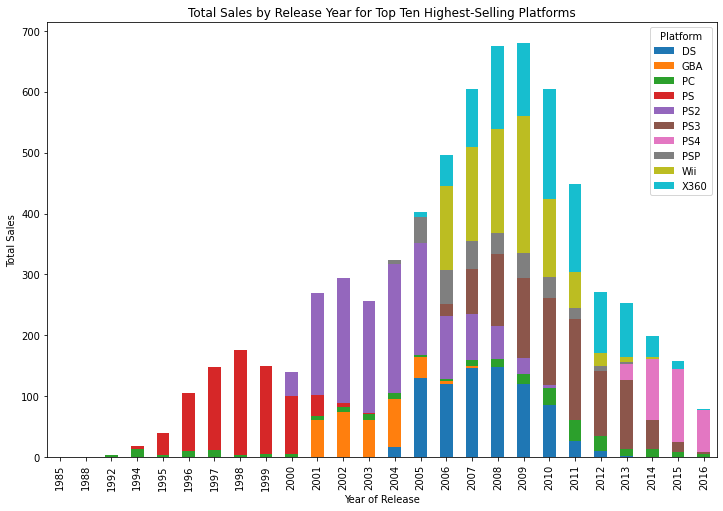

In [18]:
# get top five platforms by total sales
top_ten_platforms = top_platforms.iloc[:10]['platform']

# filter df for platforms in top_ten_platforms
df_top_ten = df[df['platform'].isin(top_ten_platforms)]

# group the top ten platforms by year and calculate the total sales for each year
df_top_ten_grouped = df_top_ten.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

# plot a histogram of total sales by year for the top ten platforms by platform
df_top_ten_grouped.pivot(index='year_of_release',columns='platform',values='total_sales').plot(
    kind='bar',
    stacked=True,
    figsize=(12,8))

# add labels and title to the plot
plt.xlabel('Year of Release')
plt.ylabel('Total Sales')
plt.title('Total Sales by Release Year for Top Ten Highest-Selling Platforms')

# name the legend
plt.legend(title='Platform')

# display the plot
plt.show()


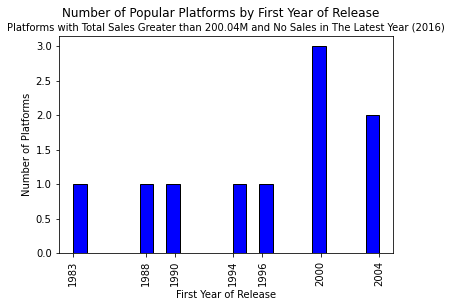

In [19]:
# plot a histogram of the number of platforms by first year of release for platforms with total sales greater than 200.04M and no sales in 2016
popular_games['min_year_of_release'].plot(
    kind='hist',
    edgecolor='black',
    color='blue',
    bins=23
    )

# add labels and title to the plot
plt.xlabel('First Year of Release')
plt.ylabel('Number of Platforms')
plt.title('Platforms with Total Sales Greater than 200.04M and No Sales in The Latest Year (2016)', fontsize=10)

# add a super title to the plot
plt.suptitle('Number of Popular Platforms by First Year of Release')

# set x-axis limits and ticks  
plt.xlim([popular_games['min_year_of_release'].min() - 1, popular_games['min_year_of_release'].max() + 1])
plt.xticks(rotation=90, ticks=[1983, 1988, 1990, 1994, 1996, 2000, 2004], ha='center')

# display the plot
plt.show()

There was an average of 3.16 years between popular, new platforms coming out.

## Modify Data Set to the Relevant Timeframe for the Remaining Analysis

Total sales by platform, year of release:

platform           3DS     DS     PC   PS2     PS3     PS4    PSP    PSV  \
year_of_release                                                            
2011             63.20  26.18  35.03  0.45  165.09     NaN  17.82   4.63   
2012             51.36  11.01  23.22   NaN  107.36     NaN   7.69  16.19   
2013             57.76   1.54  12.38   NaN  113.25   25.99   3.14  10.59   
2014             43.76    NaN  13.28   NaN   47.76  100.00   0.24  12.16   
2015             27.78    NaN   8.52   NaN   16.82  118.90   0.12   6.25   
2016             15.14    NaN   5.25   NaN    3.60   69.25    NaN   4.25   

platform           Wii   WiiU    X360   XOne  
year_of_release                               
2011             59.65    NaN  143.84    NaN  
2012             21.71  17.56   99.74    NaN  
2013              8.59  21.65   88.58  18.96  
2014              3.75  22.03   34.74  54.07  
2015              1.14  16.35   11.96  60.14  
2016              0

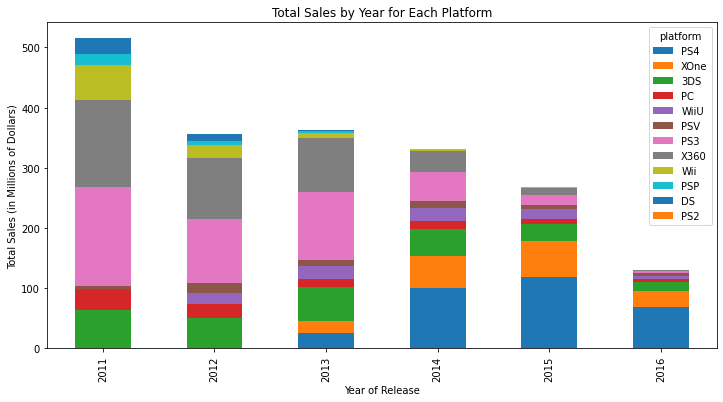

In [20]:
# trim dataset for analysis to only include data from the last 5 years based on a mean of 9.4 active years for popular platforms (only include platforms in early to mid-lifecycle)
modern_df = df[df['year_of_release'] >= 2011]

# group the data by platform and year of release and calculate the total sales for each year
grouped_sales = modern_df.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

# pivot the grouped data to create a bar plot of total sales by year for each platform
grouped_sales_pivot = grouped_sales.pivot(index='year_of_release',columns='platform',values='total_sales')

# print grouped_sales_pivot
print(f"Total sales by platform, year of release:\n\n{grouped_sales_pivot}")

# create a new order for the platforms based on total sales in 2016 descending
new_order = ['PS4', 'XOne', '3DS', 'PC', 'WiiU', 'PSV', 'PS3', 'X360', 'Wii', 'PSP', 'DS', 'PS2']

# reorder the columns in grouped_sales_pivot
grouped_sales_pivot = grouped_sales_pivot[new_order]

# plot a bar plot of total sales by year for each platform
grouped_sales_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
    )

# add labels and title to the plot
plt.xlabel('Year of Release')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Year for Each Platform')

# display the plot
plt.show()



It looks like PS4 would be the most popular platform in 2017, based on historical trends. XOne could also be a good option to make a new advertising campaign about since it is also rising in sales YoY and early in the typical platform lifecycle (but to a lesser degree than PS4).

3DS, PC, PS3, PSP, PSV, Wii, WiiU, and X360  are all falling in sales YoY.

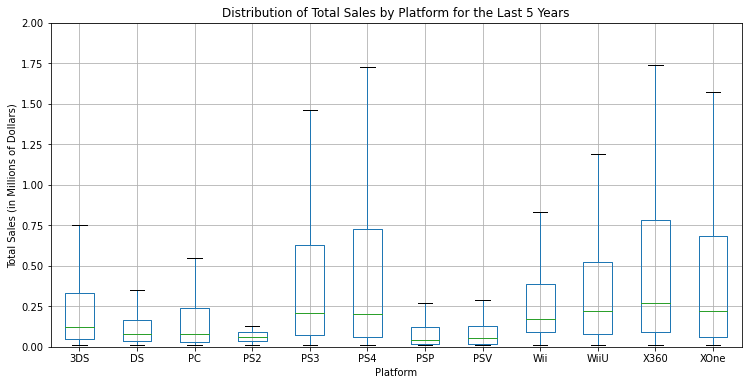

In [21]:
# build a boxplot of total sales by platform for the last 5 years
modern_df.boxplot(
    column='total_sales',
    by='platform',
    figsize=(12,6),
    showfliers = False
    )

# add a ylimit to the plot to make it easier to see the data
plt.ylim([0, 2])

# add labels and title to the plot
plt.xlabel('Platform')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Distribution of Total Sales by Platform for the Last 5 Years')

# remove the suptitle
plt.suptitle('')

# display the plot
plt.show()

The differences in sales by platform are significant. More modern or recently released platforms tend to have higher median total sales and upper bounds than older platforms. These more modern platforms also seemingly have a greater amount of variation and number of games that classify as exceptionally performing outliers. These outliers will drive up the avg. total sales of these popular platforms.

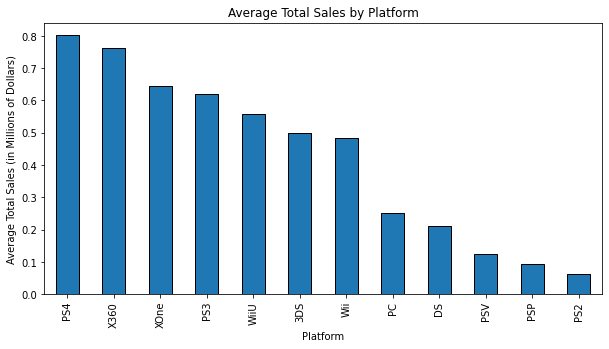

In [22]:
# group the data by platform and calculate the average total sales for each platform for the last 5 years
grouped_sales_modern = modern_df.groupby('platform')['total_sales'].mean().sort_values(ascending=False)

# plot a bar plot of average total sales by platform for the last 5 years
grouped_sales_modern.plot(
    kind='bar',
    figsize=(10,5),
    edgecolor='black'
    )

# add labels and title to the plot
plt.xlabel('Platform')
plt.ylabel('Average Total Sales (in Millions of Dollars)')
plt.title('Average Total Sales by Platform')

# display the plot
plt.show()

As expected, the more modern platforms like PS4 and XOne have higher average total sales than older platforms like PSP and DS. The more modern platforms are also in their early-mid platform lifecycle and likely draw more popular game releases, which can lead to high-performing outliers that drive their avg. sales up. Even though XOne is more modern than X360, it is earlier in its platform lifecycle and will likely surpass X360 in avg. total sales in a few more years once it achieves its peak popularity.

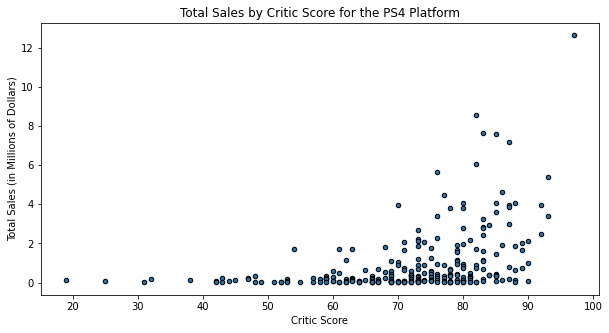

In [23]:
# create a scatter plot of total sales by critic score for the last 5 years for the PS4 platform
modern_df[modern_df['platform'] == 'PS4'].plot(
    kind='scatter',
    x='critic_score',
    y='total_sales',
    figsize=(10,5),
    edgecolor='black'
    )

# add labels and title to the plot
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Critic Score for the PS4 Platform')

# display the plot
plt.show()

There appears to be a moderate positive correlation or relationship between critic score and total sales for the PS4 platform. The higher the critic score, the higher the total sales.
    
This relationship appears especially strong once the critic score is above 70. Games with critic scores above 70 tend to have higher total sales than games with critic scores below 70.

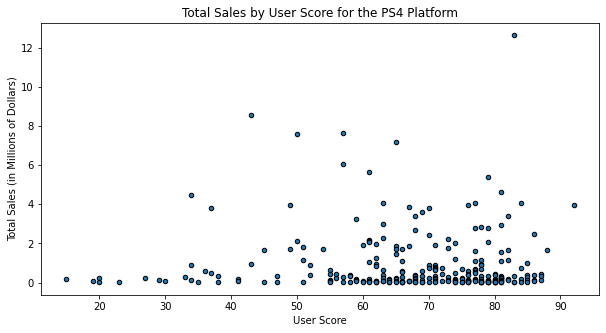

In [24]:
# create a scatter plot of total sales by user score for the last 5 years for the PS4 platform
modern_df[modern_df['platform'] == 'PS4'].plot(
    kind='scatter',
    x='user_score',
    y='total_sales',
    figsize=(10,5),
    edgecolor='black'
    )

# add labels and title to the plot
plt.xlabel('User Score')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by User Score for the PS4 Platform')

# display the plot
plt.show()

There appears to be a weak positive relationship or correlation between total sales and user score. While there is a group of games that tend to sell better when the `user_score` is above 60 or so, many games with high user scores do not sell particularly well. Some games with relatively low user scores (a 50 or lower) sell better than games with higher scores as well.

This relationship is weaker than that between total sales and critic score.

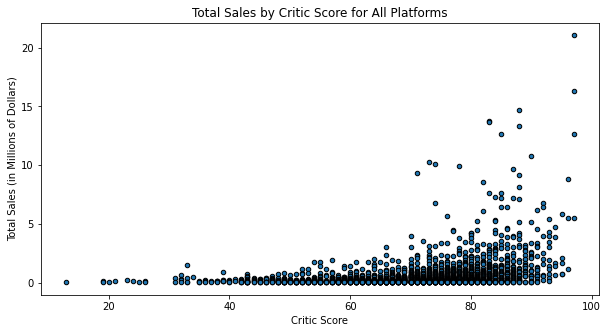

In [25]:
# create a scatterplot of total sales by critic score for the last 5 years for all platforms
modern_df.plot(
    kind='scatter',
    x='critic_score',
    y='total_sales',
    figsize=(10,5),
    edgecolor='black'
    )

# add labels and title to the plot
plt.xlabel('Critic Score')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Critic Score for All Platforms')

# display the plot
plt.show()


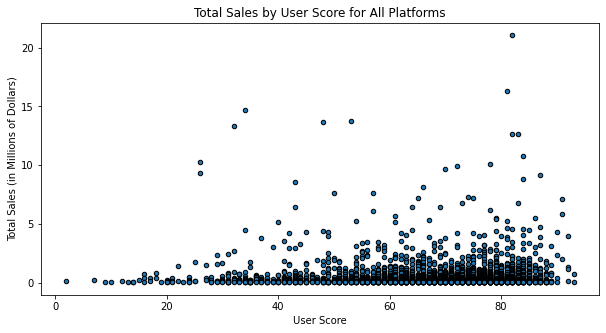

In [26]:
# create a scatterplot of total sales by user score for the last 5 years for all platforms 
modern_df.plot(
    kind='scatter',
    x='user_score',
    y='total_sales',
    figsize=(10,5),
    edgecolor='black'
    )

# add labels and title to the plot
plt.xlabel('User Score')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by User Score for All Platforms')

# display the plot
plt.show()

When looking at all platforms, critic score still seems to have a stronger positive relationship to total sales than user score does.

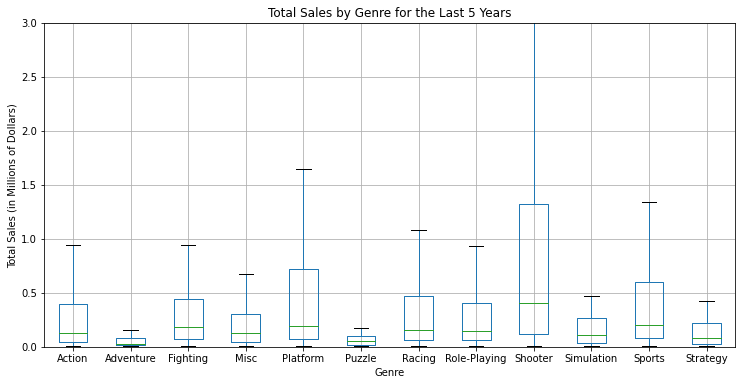

In [27]:
# build a boxplot of total sales by genre for the last 5 years
modern_df.boxplot(
    column='total_sales',
    by='genre',
    figsize=(12,6),
    showfliers = False
    )

# add a ylimit to the plot to make it easier to see the data
plt.ylim([0, 3])

# add labels and title to the plot
plt.xlabel('Genre')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Genre for the Last 5 Years')

# remove the suptitle
plt.suptitle('')

# display the plot
plt.show()

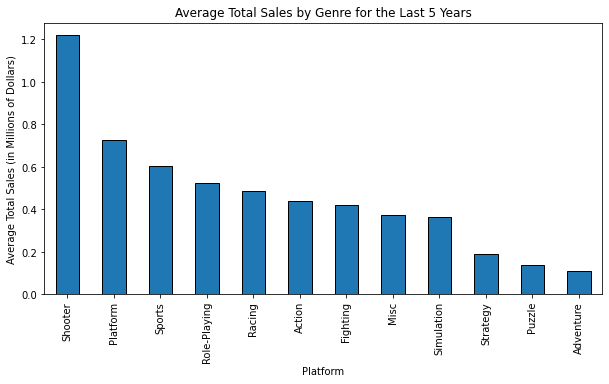

In [28]:
# group the data by genre and calculate the average total sales for each genre for the last 5 years
grouped_sales_modern_genre = modern_df.groupby('genre')['total_sales'].mean().sort_values(ascending=False)

# plot a bar plot of average total sales by genre for the last 5 years
grouped_sales_modern_genre.plot(
    kind='bar',
    figsize=(10,5),
    edgecolor='black'
    )

# add labels and title to the plot
plt.xlabel('Platform')
plt.ylabel('Average Total Sales (in Millions of Dollars)')
plt.title('Average Total Sales by Genre for the Last 5 Years')

# display the plot
plt.show()

The most profitable genres are shooter, platform, and sports. The least profitable genres are adventure and puzzle.  

We can generalize that traditional platform games maintain popularity overtime and combat-oriented or more realistic, action-heavy games perform better. Games focused on puzzles, simulations, and strategy without as much open-exploration typically don't perform as well.

# Create a User Profile for Each Region

In [29]:
'''Gather data to create user profiles for each main region.'''

# sum NA, EU, JP, and other sales for the last 5 years by platform
top_plat_region = modern_df.groupby('platform')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()

# calculate the total sales for each platform and country
top_plat_region['total_sales'] = top_plat_region['na_sales'] + top_plat_region['eu_sales'] + top_plat_region['jp_sales'] + top_plat_region['other_sales']

# calculate the percentage of total sales for each platform and country
top_plat_region['na_sales_%'] = top_plat_region['na_sales'] / top_plat_region['total_sales']
top_plat_region['eu_sales_%'] = top_plat_region['eu_sales'] / top_plat_region['total_sales']
top_plat_region['jp_sales_%'] = top_plat_region['jp_sales'] / top_plat_region['total_sales']

# sum NA, EU, JP, and other sales for the last 5 years by genre
top_genre_region = modern_df.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum()

# calculate the total sales for each genre and country
top_genre_region['total_sales'] = top_genre_region['na_sales'] + top_genre_region['eu_sales'] + top_genre_region['jp_sales'] + top_genre_region['other_sales']

# calculate the percentage of total sales for each genre and country
top_genre_region['na_sales_%'] = top_genre_region['na_sales'] / top_genre_region['total_sales']
top_genre_region['eu_sales_%'] = top_genre_region['eu_sales'] / top_genre_region['total_sales']
top_genre_region['jp_sales_%'] = top_genre_region['jp_sales'] / top_genre_region['total_sales']

# group rating data by region and calculate stats for each rating
rating_region = modern_df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].agg(['sum','count','mean','std']).reset_index()

# rename the columns
rating_region.columns = ['rating','na_total_sales','na_count_games','na_avg_sales','na_sales_std','eu_total_sales','eu_count_games','eu_avg_sales','eu_sales_std','jp_total_sales','jp_count_games','jp_avg_sales','jp_sales_std']


### Create a User Profile for the NA Region

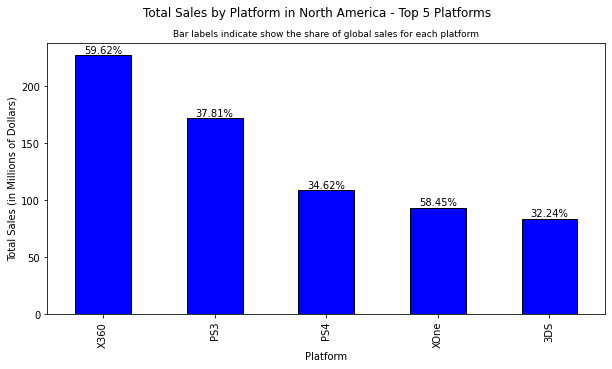

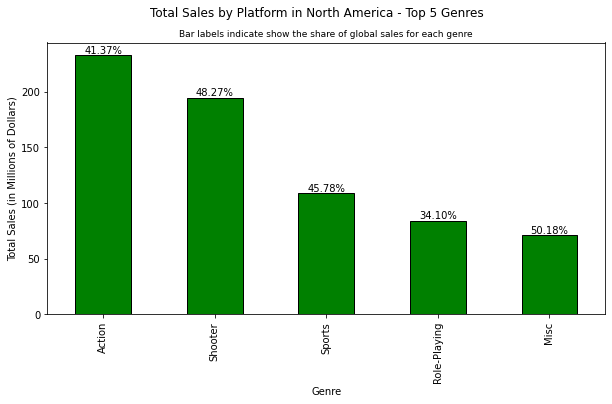

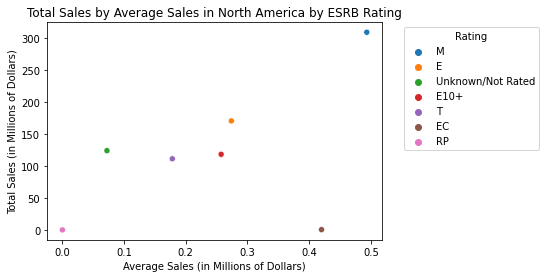

In [30]:
''' Create a user profile for the NA region.'''

# print top_five_na sorted by total sales descending
top_plat_na = top_plat_region.sort_values(by='na_sales', ascending=False).iloc[:5,[0,5]]

# plot a bar graph of na_sales by platform from top_plat_na and include the values from na_sales_% as labels
top_plat_na['na_sales'].plot(
    kind='bar',
    figsize=(10,5),
    color='blue',
    edgecolor='black'
    )

# add axis-labels and title to the plot
plt.xlabel('Platform')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.suptitle('Total Sales by Platform in North America - Top 5 Platforms')
plt.title('Bar labels indicate show the share of global sales for each platform', fontsize=9)

# add the percentage of total sales for each platform as bar labels
for i in range(len(top_plat_na)):
    plt.text(x=i, y=top_plat_na.iloc[i]['na_sales'] + 2, s=f"{top_plat_na.iloc[i]['na_sales_%']:.2%}", ha='center')

# display the plot
plt.show()

# print top_genre_na sorted by total sales descending
top_genre_na = top_genre_region.sort_values(by='na_sales', ascending=False).iloc[:5,[0,5]]

# plot a bar graph of na_sales by genre from top_genre_na and include the values from na_sales_% as labels
top_genre_na['na_sales'].plot(
    kind='bar',
    figsize=(10,5),
    color='green',
    edgecolor='black'
    )

# add axis-labels and title to the plot
plt.xlabel('Genre')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.suptitle('Total Sales by Platform in North America - Top 5 Genres')
plt.title('Bar labels indicate show the share of global sales for each genre', fontsize=9)

# add the percentage of total sales for each genre as bar labels
for i in range(len(top_genre_na)):
    plt.text(x=i, y=top_genre_na.iloc[i]['na_sales'] + 2, s=f"{top_genre_na.iloc[i]['na_sales_%']:.2%}", ha='center')

# display the plot
plt.show()

# print rating_na sorted by total sales descending
rating_na = rating_region.sort_values(by='na_total_sales', ascending=False).iloc[0:,0:5]

# plot a scatter plot of rating_na with na_avg_sales on the x-axis and na_total_sales on the y-axis colored by rating
sns.scatterplot(
    x='na_avg_sales', 
    y='na_total_sales', 
    hue='rating', 
    data=rating_na)

# add axis-labels and title to the plot
plt.xlabel('Average Sales (in Millions of Dollars)')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Average Sales in North America by ESRB Rating')

# change the legend position to be outside plot and set its title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Rating')

# display the plot
plt.show()

NA Region User Profile:
- Platform:

    - The XBox platforms are particularly popular in NA. For X360 and XOne respectively, NA makes up 59.6% and 58.4% of the total global sales. X360 brought in the most NA sales in the last five years.
    
    - PS3 and PS4 are also popular platforms as the second and third top-selling platforms in NA, respectively. However, the EU has a higher share of global sales at 44.9% vs. NA's share of 34.6%.
- Genre:
    - Action and shooter games are the most popular genres in NA with 41.3% and 48.2% of global market share respectively. The sports genre has 45.7% global market share but its total sales over the past five years are 44% less than those of the second most popular genre of shooter.
- ESRB Rating:

    - In NA, games with an ESRB rating of M (mature) bring in the most sales by a signficant amount even though there have been roughly a comparable number of released games in other ESRB rating categories.

    - The second best-selling genre in NA is E (everyone). The ESRB rating of T (teen) is the lowest selling rating of any rating with a non-neglible number of released games. This tells us that, in NA, sales don't necessarily have a linear relationship with the age rating each rating represents, but instead that best selling games typically fall into rating categories geared toward adults that either are generally appropriate or have mature content. Of note, games with a M rating have a higher standard deviation around their mean sales than those with an E rating; there is more variability in the success of mature games.
    
    - The 'Unknown/Not Rated' rating lies somewhere in the middle of the rankings of NA sales by rating. This makes sense because it is likely a mixture of different ratings and also may represent lesser known games. This is confirmed by its low NA avg. sales figure relative to the other ratings.


### Create a User Profile for the EU Region

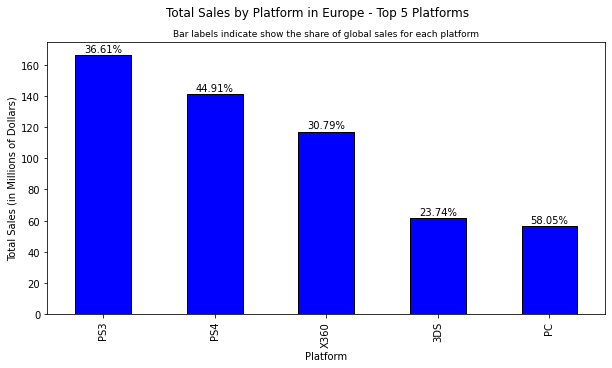

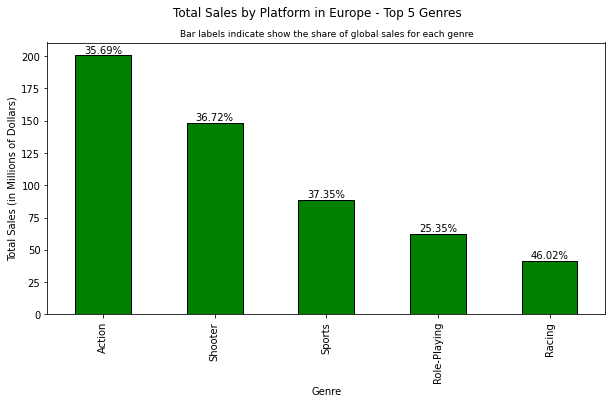

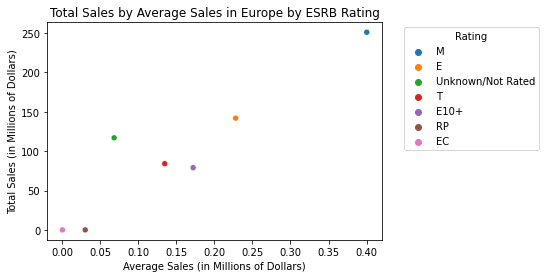

In [31]:
''' Create a user profile for the EU region.'''

# print top_five_eu sorted by total sales descending
top_plat_eu = top_plat_region.sort_values(by='eu_sales', ascending=False).iloc[:5,[1,6]]

# plot a bar graph of eu_sales by platform from top_plat_eu and include the values from eu_sales_% as labels
top_plat_eu['eu_sales'].plot(
    kind='bar',
    figsize=(10,5),
    color='blue',
    edgecolor='black'
    )

# add axis-labels and title to the plot
plt.xlabel('Platform')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.suptitle('Total Sales by Platform in Europe - Top 5 Platforms')
plt.title('Bar labels indicate show the share of global sales for each platform', fontsize=9)

# add the percentage of total sales for each platform as bar labels
for i in range(len(top_plat_eu)):
    plt.text(x=i, y=top_plat_eu.iloc[i]['eu_sales'] + 2, s=f"{top_plat_eu.iloc[i]['eu_sales_%']:.2%}", ha='center')

# display the plot
plt.show()

# print top_genre_eu sorted by total sales descending
top_genre_eu = top_genre_region.sort_values(by='eu_sales', ascending=False).iloc[:5,[1,6]]

# plot a bar graph of eu_sales by genre from top_genre_eu and include the values from eu_sales_% as labels
top_genre_eu['eu_sales'].plot(
    kind='bar',
    figsize=(10,5),
    color='green',
    edgecolor='black'
    )

# add axis-labels and title to the plot
plt.xlabel('Genre')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.suptitle('Total Sales by Platform in Europe - Top 5 Genres')
plt.title('Bar labels indicate show the share of global sales for each genre', fontsize=9)

# add the percentage of total sales for each genre as bar labels
for i in range(len(top_genre_eu)):
    plt.text(x=i, y=top_genre_eu.iloc[i]['eu_sales'] + 2, s=f"{top_genre_eu.iloc[i]['eu_sales_%']:.2%}", ha='center')

# display the plot
plt.show()

# print rating_eu sorted by total sales descending
rating_eu = rating_region.sort_values(by='eu_total_sales', ascending=False).iloc[0:,[0,5,6,7,8]]

# plot a scatter plot of rating_eu with eu_avg_sales on the x-axis and eu_total_sales on the y-axis colored by rating
sns.scatterplot(
    x='eu_avg_sales', 
    y='eu_total_sales', 
    hue='rating', 
    data=rating_eu)

# add axis-labels and title to the plot
plt.xlabel('Average Sales (in Millions of Dollars)')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Average Sales in Europe by ESRB Rating')

# change the legend position to be outside plot and set its title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Rating')

# display the plot
plt.show()


EU Region User Profile:
- Platform:

  - PS3 and PS4 and the top two platforms in the EU with 36.6% and 44.9% of global market share, respectively.

  - The PlayStation platforms are more popular in the EU whereas the XBox platforms are more popular in NA.
    - The newer PS4 platform has become more popular or more quickly adopted in the EU whereas the newer XOne platform has become more popular or more quickly adopted in NA; XOne isn't even in the top five platforms for the EU over the past five years.

- Genre:

  - The top four genres in the EU (action, shooter, sports, and role-playing, respectively) are the same as the top four genres in NA, however they all command lower global market shares than NA does.

  - The fifth most popular genre in the EU is racing with a 46.0% global market share. This is a uniquely popular genre in EU and likely reflects a unique aspect of its culture--perhaps a love of F1 racing.

- ESRB Rating:

  - In the EU, sales are affected by rating very similarly as they are in NA; games with a rating of M (mature) perform best with E (everyone) rated games following in second place. These two categories greatly outperform other ratings.

  - In contrast to NA , T (teen) rated games perform better than E10+ (everyone 10+) games.
  - Similar to NA, 'Unknown/Not Rated' games represent a mix of all categories and unsurprisingly fall within the middle of total EU sales rankings by rating. 

### Create a User Profile for the JP Region

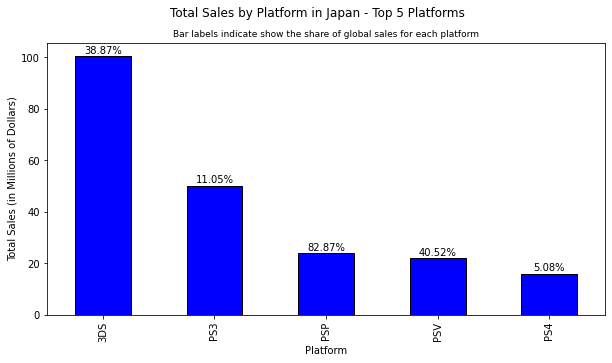

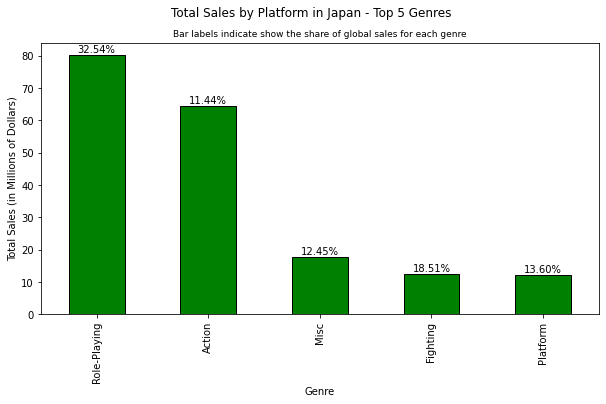

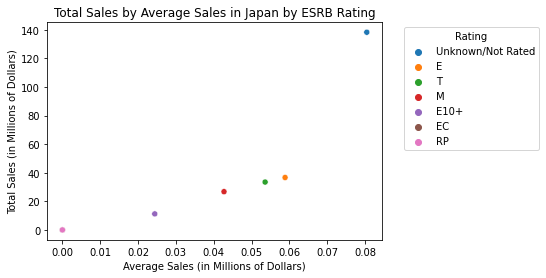

In [32]:
''' Create a user profile for the JP region.'''

# print top_five_jp sorted by total sales descending
top_plat_jp = top_plat_region.sort_values(by='jp_sales', ascending=False).iloc[:5,[2,7]]

# plot a bar graph of jp_sales by platform from top_plat_jp and include the values from jp_sales_% as labels
top_plat_jp['jp_sales'].plot(
    kind='bar',
    figsize=(10,5),
    color='blue',
    edgecolor='black'
    )

# add axis-labels and title to the plot
plt.xlabel('Platform')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.suptitle('Total Sales by Platform in Japan - Top 5 Platforms')
plt.title('Bar labels indicate show the share of global sales for each platform', fontsize=9)

# add the percentage of total sales for each platform as bar labels
for i in range(len(top_plat_jp)):
    plt.text(x=i, y=top_plat_jp.iloc[i]['jp_sales'] + 1, s=f"{top_plat_jp.iloc[i]['jp_sales_%']:.2%}", ha='center')

# display the plot
plt.show()

# print top_genre_jp sorted by total sales descending
top_genre_jp = top_genre_region.sort_values(by='jp_sales', ascending=False).iloc[:5,[2,7]]

# plot a bar graph of jp_sales by genre from top_genre_jp and include the values from jp_sales_% as labels
top_genre_jp['jp_sales'].plot(
    kind='bar',
    figsize=(10,5),
    color='green',
    edgecolor='black'
    )

# add axis-labels and title to the plot
plt.xlabel('Genre')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.suptitle('Total Sales by Platform in Japan - Top 5 Genres')
plt.title('Bar labels indicate show the share of global sales for each genre', fontsize=9)

# add the percentage of total sales for each genre as bar labels
for i in range(len(top_genre_jp)):
    plt.text(x=i, y=top_genre_jp.iloc[i]['jp_sales'] + 1, s=f"{top_genre_jp.iloc[i]['jp_sales_%']:.2%}", ha='center')

# display the plot
plt.show()

# print rating_jp sorted by total sales descending
rating_jp = rating_region.sort_values(by='jp_total_sales', ascending=False).iloc[0:,[0,9,10,11,12]]

# plot a scatter plot of rating_jp with jp_avg_sales on the x-axis and jp_total_sales on the y-axis colored by rating
sns.scatterplot(
    x='jp_avg_sales', 
    y='jp_total_sales', 
    hue='rating', 
    data=rating_jp)

# add axis-labels and title to the plot
plt.xlabel('Average Sales (in Millions of Dollars)')
plt.ylabel('Total Sales (in Millions of Dollars)')
plt.title('Total Sales by Average Sales in Japan by ESRB Rating')

# change the legend position to be outside plot and set its title
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Rating')

# display the plot
plt.show()

JP Region User Profile:
- Platform:

  - Handheld platforms are very popular in Japan with the first (3DS), third (PSP), and fourth (PSV) most popular platforms generating 38.9%, 82.9%, and 40.1% of global market share, respectively.

  - PS3 and PS4 are also among the most popular platforms in Japan but hold significantly lower market share than in NA and EU. 

  - XBox platforms are not very popular in Japan.

- Genre:

  - Japan's five top-selling genres are role-playing, action, misc, fighting, and platform, which, beside the overlap in the popular of action games with NA and EU, are very different than the most popular genres in NA and EU.
    - Despite the popularity of these genres in Japan, they hold only 10-20% of global market share with the exception of the role-playing genre, which holds a 32.5% global market share.

- ESRB Rating:

  - In Japan, most sales are associated with 'Unknown/Not Rated' games, which may represent a lower likelihood for Japanese games to be rated. 

  - Within the realm of games with a known ESRB rating, E-rated (everyone) games in Japan sell the best while M-rated (mature) games sell third-best after T-rated (T) games. 

    - Similar to NA and EU, there isn't a linear relationship between sales and the age category the ESRP rating represents. 
    - Unlike NA and EU, mature games are not the most popular in Japan. 
      - Perhaps Japan has a more modest culture or the video gaming culture among adults is less pravalent. 

# Test Hypotheses About the Data Set

### Hypothesis #1

Test the hypothesis that the average user rating of the Xbox One and PC platforms are the same.
 - Null Hypothesis: The average user rating of Xbox One and PC platforms are the same.
 - Alternative Hypothesis: The average user rating of Xbox One and PC platforms are not the same.

In [33]:
# store user ratings for XOne games over the last five years in a variable
xone_ratings_samp = modern_df.loc[modern_df['platform'] == 'XOne','user_score'].dropna()

# store user ratings for PC games over the last five years in a variable
pc_ratings_samp = modern_df.loc[modern_df['platform'] == 'PC','user_score'].dropna()

# set the critical statistical significance level
alpha = 0.05

# apply the independent two-sample t-test method to the samples
results = st.ttest_ind(xone_ratings_samp, pc_ratings_samp, equal_var=False)

# print the p-value
print('p-value: ', results.pvalue)

# if the p-value is less than alpha, we reject the hypothesis
if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

p-value:  0.613071224763855
We can't reject the null hypothesis.


Since our hypothesis is testing whether the averages of the two samples are equal, our null hypothesis states that they are because a null hypothesis reflects the condition of the two samples not being statistically significantly different i.e. it is highly unlikely that the two samples are different by chance alone. 

We chose the standard critical significance level of 0.05% to reflect an outcome that would occur outside of three standard deviations of the mean, assuming the two samples' means are equal.

The p-value is higher than 0.05, which means we can't reject the null hypothesis; the avg. user rating for Xbox One and PC games are the same.

We also chose an independent two-sample t-test to test this hypothesis because it does not matter how the two samples' means may be different from one another (relatively higher or lower); it only matters that they are the same or different, to a statistically significant degree, in any way.

### Hypothesis #2

Test the hypothesis that the average user rating for the Action and Sports genres are different.
 - Null Hypothesis: The average user rating for the Action and Sports genres are the same.
 - Alternative Hypothesis: The average user rating for the Action and Sports genres are not the same.

In [34]:
# store user ratings for the Action genre over the last five years in a variable
action_ratings_samp = modern_df.loc[modern_df['genre'] == 'Action','user_score'].dropna()

# store user ratings for the Sports genre over the last five years in a variable
sports_ratings_samp = modern_df.loc[modern_df['genre'] == 'Sports','user_score'].dropna()

# set the critical statistical significance level
alpha = 0.05

# apply the independent two-sample t-test method to the samples
results = st.ttest_ind(action_ratings_samp, sports_ratings_samp, equal_var=False)

# print the p-value
print('p-value: ', results.pvalue)

# if the p-value is less than alpha, we reject the hypothesis
if results.pvalue < alpha:
    print("We reject the null hypothesis.")
else:
    print("We can't reject the null hypothesis.")

print()
print("Mean user score for the action genre: ", action_ratings_samp.mean().round(1))
print("Mean user score for the sports genre: ", sports_ratings_samp.mean().round(1))

p-value:  5.7748521869722745e-19
We reject the null hypothesis.

Mean user score for the action genre:  67.8
Mean user score for the sports genre:  56.6


The p-value is lower than the critical significance level of 0.05, which means we reject the null hypothesis; the average user score of action and sports genres are different at a statistically significant degree. The average user score for the action genre is 67.8, which is 19.8% higher than the average user score for the sports genre (56.6).

The reasons for choosing the critical statistical significance level of 0.05 and using an independent two-sample t-test are the same as for hypothesis # 1. 

It does not matter that the hypothesis is that our two samples' means are different. Our null hypothesis states will still state that they are the same are because a null hypothesis reflects the condition of the two samples not being statistically significantly different i.e. it is highly unlikely that the two samples are different by chance alone. 

# Conclusion

Based on the conducted analysis, the following insights can help predict which advertising campaign for a game in 2017 will be most successful:

1. Platform Selection: The PlayStation 4 (PS4) and Xbox One (Xone) platforms were the most popular platforms in terms of total sales and platform lifecycle potential based on the typical lifespan of a platform and YoY sales growth. Therefore, focusing on these platforms would likely yield the highest potential sales.

2. Genre Consideration: Action, Shooter, and Sports were the top-selling genres. Developing a game within these genres would align with consumer preferences and increase the chances of success.

3. Critic and User Ratings: Critic ratings showed a moderate impact on game sales while user ratings had a weaker effect. Games with higher critic scores tended to sell better, especially when they were rated above 70. Therefore, prioritizing quality and ensuring positive user experiences can lead to higher sales. It would also be important to get the game reviewed by critics as early as possible to build anticipation for the game.

4. Regional Differences: It is important to consider regional variations in game preferences. For example, the North American and European markets showed a preference for games with "M" (Mature) and "E" (Everyone) ratings, while the Japanese market had a higher preference for games with "E" and "T" (Teen) ratings. Adapting the game's content and marketing strategy to cater to regional preferences can enhance sales. However, given that the North American and European markets command a high global market share combined, a game with a "M" (mature) rating would most likely perform best followed by one with an "E" (everyone) rating.

5. Marketing and Promotion: Investing in effective marketing and promotion campaigns is crucial for creating awareness and generating interest in the game. Leveraging social media, influencers, and targeted advertising can help reach the target audience and drive sales.

6. Multi-platform Release: Releasing the game on multiple platforms, especially PS4 and XOne, can expand the potential customer base and increase overall sales.

In conclusion, the best strategy for planning advertising campaigns for big upcoming game releases in 2017 would involve identifying a high-quality game in the Action, Shooter, or Sports genres, targeting the PS4 and XOne platforms, with a "M" or "E" ESRB rating. Effective marketing and promotion strategies should be implemented in the North American and European markets that consider seasonality for optimal release timing and the most high-reaching, ROI-driven advertising channels within each market. Advertising should be heavier for Xbox One in North America and heavier for PS4 in Europe. 
